# VAR/SVAR 模型相關程式

### 簡要Summary

* 編號：v4i1-chol

1. 4個變數：利率、許可建照數、房屋貸款、房價指數

2. 認定條件是：Wold Ordering

### 環境設定

In [1]:
# 設定路徑
Path = "/Users/Andy 1/Google 雲端硬碟 (r08323004@g.ntu.edu.tw)/0 Semesters/Thesis/6_VAR_model/R"
setwd(Path)
source("code/VAR_functions.R")           # 讀取 VARsource.R 檔

inv_tol = 1e-20 #求反矩陣時做數值運算允許的最小誤差(避免singular matrix)
#inv_tol = 1e-22

─ Attaching packages ──────────────────── tidyverse 1.3.0 ─

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: matrixcalc

Loading required package: lattice

Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘pack

In [2]:
#options(warn=-1)    # 關掉warning
options(warn=0)
options(scipen=999) #不要科學記號

### 讀資料

In [3]:
###### 讀取資料 ######
file = "data/df.csv"
data = read.csv(file = file, header = TRUE)
data = na.omit(data)
# 4-variable model
By <- data %>% select(interest_rate, permit, loan, hp) %>% as.matrix

### 模型設定

In [4]:
#----- 模型設定 -----#
VAR.P = 2                       # 最大的落後項數
CONST = TRUE                    # 是否有常數項
Y     = VAR.Y(By, VAR.P)        # 設定 Y
X     = VAR.X(By, VAR.P)        # 設定 X

## Reduced Form VAR

In [5]:
###### 參數估計 ######
(Coef.OLS    = VAR.OLS(Y, X, CONST)                  )
(Sigma.OLS   = VAR.Sigma.OLS(Y, X, Coef.OLS, CONST)  )
(Sigma.MLE   = VAR.Sigma.MLE(Y, X, Coef.OLS, CONST))

0.7621786,0.00002057155,0.000002393992,0.01094977,0.1653186,0.000009927274,-0.000002273023,-0.009473075,-0.630320
579.0720720,0.48742141925,-0.003159199737,99.97290722,-629.2498381,0.336192230427,0.001284627003,-123.087459382,8587.792971
2620.5390285,-5.30957445462,1.663250110087,-238.48021499,-2379.7188003,5.178203823264,-0.689118821123,-73.599900806,94464.765683
-0.6100043,-0.00005540104,-0.000006700314,1.31005057,-0.1365505,0.000234511108,0.000006517635,-0.322453659,3.898298


0.20993059,36.55305,2149.290,-0.02212806
36.55304771,1074253.79245,1622044.452,1168.15779973
2149.28969453,1622044.45153,691376008.768,-3478.28383841
-0.02212806,1168.15780,-3478.284,13.20133557


0.1937821,33.74127,1983.960,-0.0204259
33.7412748,991618.88534,1497271.801,1078.2995074
1983.9597180,1497271.80141,638193238.862,-3210.7235431
-0.0204259,1078.29951,-3210.724,12.1858482


### AIC/SIC

In [6]:
#----- 資訊準則 -----#
A0.Mat = matrix(1, 3, 7)
(SIC = VAR.IC(Sigma.MLE, A0.Mat, T)$SIC              )

(IC = VAR.Select(By, Max.lag = 4, CONST)             )
apply(IC, 1, which.min)

[1] 34.79463

AIC,36.47904,35.41002,35.41892,35.29343
SIC,36.94864,36.25992,36.65329,36.91652
HQ,36.66971,35.75507,35.92000,35.95224


AIC SIC  HQ 
  4   2   2

# SVAR

## Identification

$$
\left[
\begin{array}{c}
	\varepsilon_t^i\\
	\varepsilon_t^{permit}\\
	\varepsilon_t^{loan}\\
	\varepsilon_t^{hp}
\end{array}
\right]
=
\left[
\begin{array}{ccccc}
a_{11} &0 &0 &0\\
a_{21} &a_{22} &0 &0\\
a_{31} &a_{32} &a_{33} &0\\
a_{41} &a_{42} &a_{43} &a_{44}\\
\end{array}
\right]
\left[
\begin{array}{c}
	e_t^{mp}\\
	e_t^{hs}\\
	e_t^{hd}\\
	e_t^{sp}
\end{array}
\right]
$$

In [7]:
### 4-variable model

Amat = diag(4)
# Identification Conditions

Amat[2,1]  = NA; 
Amat[3,1]  = NA; Amat[3,2]  = NA;
Amat[4,1]  = NA; Amat[4,2]  = NA; Amat[4,3]  = NA;

Bmat = diag(4)
diag(Bmat) = NA

Amat;Bmat

1,0,0,0
NA,1,0,0
NA,NA,1,0
NA,NA,NA,1


NA,0,0,0
0,NA,0,0
0,0,NA,0
0,0,0,NA


## 估計 $\hat{A} , \hat{B}$

* Recall 模型設定:

$$D(L)Y_t = Be_t$$

可以推得:

$$Y_t = \Phi_1 Y_{t-1} + \dots + \Phi_p Y_{t-p} + \varepsilon_t $$

1. 為 $A, B$ matrix 加上 zero constraints

2. 從$\Sigma_\varepsilon = CC'$知道 cholesky decomposition的 $C = (I-D_0)^{-1}B = A^{-1}B$ 

In [8]:
C.Prime <- chol(Sigma.OLS)

In [9]:
C <- t(C.Prime)
C

0.45818183,0.000000,0.0000000,0.000000
79.77847586,1033.387240,0.0000000,0.000000
4690.90997208,1207.495850,25844.0191567,0.000000
-0.04829537,1.134145,-0.1788116,3.446846


令 

$$
A = \left[
\begin{array}{ccccc}
1 &0 &0 &0\\
a_{21} &1 &0 &0\\
a_{31} &a_{32} &1 &0\\
a_{41} &a_{42} &a_{43} &1\\
\end{array}
\right]
$$

$$
B = \left[
\begin{array}{ccccc}
\sigma_1 &0 &0 &0\\
0 &\sigma_2 &0 &0\\
0 &0 &\sigma_3 &0\\
0 &0 &0 &\sigma_4\\
\end{array}
\right]
$$

則

$$
AC = \left[
\begin{array}{ccccc}
1 &0 &0 &0\\
a_{21} &1 &0 &0\\
a_{31} &a_{32} &1 &0\\
a_{41} &a_{42} &a_{43} &1\\
\end{array}
\right]
\left[
\begin{array}{ccccc}
c_{11} &0 &0 &0\\
c_{21} &c_{22} &0 &0\\
c_{31} &c_{32} &c_{33} &0\\
c_{41} &c_{42} &c_{43} &c_{44}\\
\end{array}
\right]
\\=
\left[
\begin{array}{ccccc}
c_{11} &0 &0 &0\\
a_{21}c_{11}+c_{21} &c_{22} &0 &0\\
a_{31}c_{11}+a_{32}c_{21}+c_{31} &a_{32}c_{22}+c_{32} &c_{33} &0\\
a_{41}c_{11}+a_{42}c_{21}+a_{43}c_{31}+c_{41} &a_{42}c_{22}+a_{43}c_{32}+c_{42} &a_{43}c_{33}+c_{43} &c_{44}\\
\end{array}
\right]
=B
$$

也就是要解以下的線性系統:

共六條方程式

In [10]:
A0 <- Amat

In [11]:
A0[2,1] <- -C[2,1]/C[1,1]
A0[3,2] <- -C[3,2]/C[2,2]
A0[3,1] <- (-C[3,1]+(C[2,1]*C[3,2]/C[2,2]))/C[1,1]

A0[4,3] <- -C[4,3]/C[3,3]
A0[4,2] <- (-C[4,2]+C[3,2]*C[4,3]/C[3,3])/C[2,2]
A0[4,1] <- (-1/C[1,1])*( (C[3,2]*C[4,3]*C[2,1]/C[3,3] - C[4,2]*C[2,1])/C[2,2] - (C[4,3]*C[3,1]/C[3,3]) + C[4,1] )

In [12]:
A0

1.0000000,0.000000000,0.000000000000,0
-174.1196866,1.000000000,0.000000000000,0
-10034.6410306,-1.168483414,1.000000000000,0
0.2270749,-0.001105587,0.000006918876,1


In [13]:
B0 <- Bmat
B0

NA,0,0,0
0,NA,0,0
0,0,NA,0
0,0,0,NA


In [14]:
B0[1,1] <- C[1,1]
B0[2,2] <- C[2,2]
B0[3,3] <- C[3,3]
B0[4,4] <- C[4,4]

In [15]:
B0

0.4581818,0.000,0.00,0.000000
0.0000000,1033.387,0.00,0.000000
0.0000000,0.000,25844.02,0.000000
0.0000000,0.000,0.00,3.446846


In [16]:
solve(A0)

1.0000000,0.000000000,0.000000000000,0
174.1196866,1.000000000,0.000000000000,0
10238.0969965,1.168483414,1.000000000000,0
-0.1054066,0.001097502,-0.000006918876,1


In [17]:
solve(A0) %*% B0

0.45818183,0.000000,0.0000000,0.000000
79.77847586,1033.387240,0.0000000,0.000000
4690.90997208,1207.495850,25844.0191567,0.000000
-0.04829537,1.134145,-0.1788116,3.446846


In [18]:
C

0.45818183,0.000000,0.0000000,0.000000
79.77847586,1033.387240,0.0000000,0.000000
4690.90997208,1207.495850,25844.0191567,0.000000
-0.04829537,1.134145,-0.1788116,3.446846


In [19]:
solve(A0) %*% B0 == C

TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE
TRUE,TRUE,TRUE,TRUE
FALSE,FALSE,FALSE,TRUE


In [20]:
SVAR_AB_est <- list("A0.svar" = A0, "B0.svar" = B0)

In [21]:
SVAR_AB_est

1.0000000,0.000000000,0.000000000000,0
-174.1196866,1.000000000,0.000000000000,0
-10034.6410306,-1.168483414,1.000000000000,0
0.2270749,-0.001105587,0.000006918876,1
0.4581818,0.000,0.00,0.000000
0.0000000,1033.387,0.00,0.000000
0.0000000,0.000,25844.02,0.000000
0.0000000,0.000,0.00,3.446846


### Note: Solving system of linear equations

由於 $B, C$已知，又$AC = B$，故$A = BC^{-1}$

In [22]:
B0 <- diag(diag(C), ncol = 4, nrow = 4)
B0

0.4581818,0.000,0.00,0.000000
0.0000000,1033.387,0.00,0.000000
0.0000000,0.000,25844.02,0.000000
0.0000000,0.000,0.00,3.446846


In [23]:
A0 <- B0 %*% solve(C)
A0

1.0000000,0.000000000,0.000000000000,0
-174.1196866,1.000000000,0.000000000000,0
-10034.6410306,-1.168483414,1.000000000000,0
0.2270749,-0.001105587,0.000006918876,1


In [24]:
SVAR_AB_est <- list("A0.svar" = A0, "B0.svar" = B0)

## IRF (without Bootstrap C.I.)

In [25]:
### IRF
SVAR_AB_IRF <- VAR.svarirf.AB(By, VAR.P, Amat, Bmat, h = 119, CONST, SVAR_AB_est = SVAR_AB_est)


# 5*5個圖的time series
df_IRF_plot <- matrix(NA, 120, 16) #%>% as.tibble()
#dim(df_IRF_plot)
h <- 0 # h表示第幾期的IRF
for(period in SVAR_AB_IRF){
  k <- 0 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
  h <- h+1 # h表示第幾期的IRF
  for(j in 1:4){
    for(i in 1:4){
      k <- k+1 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
      df_IRF_plot[h,k] <- period[i,j]
    }
  }
}
df_IRF_plot <- df_IRF_plot %>% as_tibble()

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [26]:
p1 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V1))
p2 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V2))
p3 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V3))
p4 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V4))
p5 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V5))
p6 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V6))
p7 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V7))
p8 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V8))
p9 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V9))
p10 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V10))
p11 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V11))
p12 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V12))
p13 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V13))
p14 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V14))
p15 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V15))
p16 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V16))

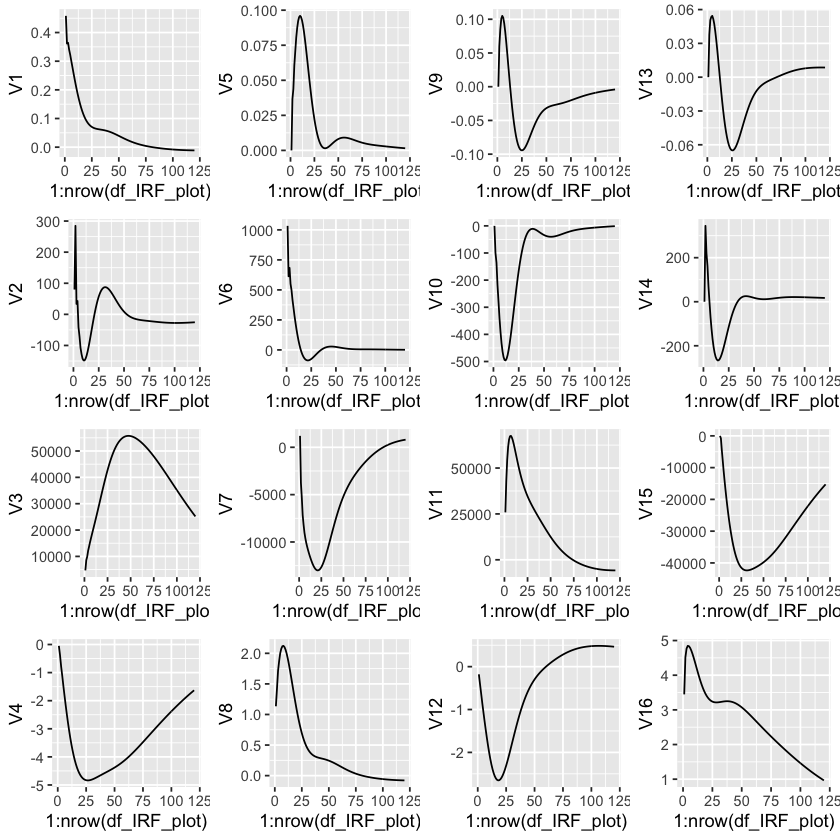

In [27]:
multiplot(p1,p2,p3,p4,
          p5,p6,p7,p8,
          p9,p10,p11,p12,
          p13,p14,p15,p16,
          cols = 4)

## IRF (Bootstrap C.I.)

Steps:

1. 從殘差取後放回重抽T個

2. 從估計值加上重抽的T個殘差，得到5條 period為T的pseudo time series

3. 從pseudo time series再估SVAR及IRF

    a. 估的時候是固定已經得到的 $\hat{A}, \hat{B}$ matrix來計算IRF
    
    b. 估的條件相似，是當重抽一組residual並得到pseudo time series後，一樣要 $se(\hat{A}), se(\hat{B})$ 存在才算進一個bootstrap statistics
    
    c. 停止條件是蒐集到1000條

4. 從IRF的2.5% quantile跟97.5%quantile找到IRF的95% C.I.

存法：用arrary：

1. row數為總期間減去lag期數

2. column數為變數總數的平方（shock1對y1,..., shock5對y5）

3. page數為Bootstrap重複的次數

```R
lower = 0.025                                        # 控制成 95% CI
upper = 1-lower
kk = ncol(By)
ddY = VAR.ddY(By, VAR.P)
ddX = VAR.ddX(By, VAR.P)
# obs:119 lag:2 -> 117
# Y: 5 vairables
# X: 5個變數的t-1, t-2 -> 10 variables
dim(ddY); dim(ddX)

T   = nrow(ddY)
T.total= nrow(By)
Ik  = diag(rep(1, kk))
# 55 coef.
Coef = t(VAR.EbyE(ddY, ddX, CONST)$ddA)              # Step 1 估計模型
# residuals
U    = VAR.EbyE(ddY, ddX, CONST)$ddU

#BSigma.u = VAR.ddSigma.OLS(ddY, ddX, CONST)
if(CONST == TRUE){
  const = Coef[, ncol(Coef)]
  Coef.noc= Coef[,-ncol(Coef)]                      # 刪掉 const
}else{
  const = matrix(0, kk, 1)
  Coef.noc = Coef
}
dm.U <- U-mean(U)
#dm.U = scale(U, scale = FALSE)                       # Step 2 減去殘差的平均數
N = 1000 #重抽次數
dim(ddX); dim(Coef.noc); dim(dm.U)
#Y.sim <- matrix(const, nrow = 117, ncol = 5, byrow = T) + ddX %*% t(Coef.noc) + dm.U

# 存N次重抽的IRF
df_IRF.sim <- array(NA, c(120,kk^2,N)) #dimensions are: Time Period, Number of shock interacts with variables, page (number of Bootstrap resamplings)
counter <- 1
while(TRUE){

  #cat("Now, there are ", counter-1, " sets of resamples.\n")
  Y.sim = matrix(0, nrow = T.total, ncol = kk)          # Y.sim = 0 #pseudo time series
  Y.sim[c(1:VAR.P),] = By[c(1:VAR.P), ]
  boot.number = sample(c(1:T), replace = TRUE)      # Step 3 取出放回
  U.sim = dm.U[boot.number,]
  
  Y.sim[-c(1:VAR.P),] <- matrix(const, nrow = 117, ncol = kk, byrow = T) + ddX %*% t(Coef.noc) + U.sim
  #`Y.sim` is the pseudo time series
  # Step 5 重新估算SVAR
  
  ### SVAR.sim Start ###

    Y_pseudo     = VAR.Y(Y.sim, VAR.P)        # 設定 Y
    X_pseudo     = VAR.X(Y.sim, VAR.P)        # 設定 X
    Coef.OLS_pseudo    = VAR.OLS(Y_pseudo, X_pseudo, CONST)
    Sigma.OLS_pseudo   = VAR.Sigma.OLS(Y_pseudo, X_pseudo, Coef.OLS_pseudo, CONST)
    C.Prime_pseudo <- chol(Sigma.OLS_pseudo)
    C_pseudo <- t(C.Prime_pseudo)
    B0_pseudo <- diag(diag(C_pseudo), ncol = 4, nrow = 4)
    A0_pseudo <- B0_pseudo %*% solve(C_pseudo)
    SVAR_AB_est.sim <- list("A0.svar" = A0_pseudo, "B0.svar" = B0_pseudo)
    SVAR_AB_IRF.sim <- VAR.svarirf.AB(Y.sim, VAR.P, Amat, Bmat, h = 119, CONST, SVAR_AB_est = SVAR_AB_est.sim)
    
  # 5*5個圖的time series
  df_IRF_plot.sim <- matrix(NA, 120, kk^2) #%>% as.tibble()
  # df_IRF.sim <- array(1:(120*25*N), c(120,25,N))
  # df_IRF.sim[2,1,1] # slicing
  
  h <- 0 # h表示第幾期的IRF
  for(period in SVAR_AB_IRF.sim){
    k <- 0 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
    h <- h+1 # h表示第幾期的IRF
    for(j in 1:kk){
      for(i in 1:kk){
        k <- k+1 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
        df_IRF_plot.sim[h,k] <- period[i,j]
      }
    }
  }
  # 把這一次重抽得到的IRF append進`df_IRF.sim`中
  df_IRF.sim[,,counter] <- df_IRF_plot.sim
  ### SVAR.sim Ends ###
  if(counter>=N){
    break
  }
  counter <- counter+1
}
```

```R
# Save
saveRDS(df_IRF.sim, file = "df_IRF.sim_v4i1-chol.rds")
```

In [30]:
df_IRF.sim <- read_rds("/Users/Andy 1/Google 雲端硬碟 (r08323004@g.ntu.edu.tw)/0 Semesters/Thesis/6_VAR_model/R/seeds/v4_identification2-chol/df_IRF.sim_v4i1-chol.rds")

In [31]:
# 看某一頁
head(df_IRF.sim[,,1000])

0.6099785,263.95386,14761.70,-0.6507697,0.000000000000000144598,1239.2267,-17889.70,3.094732,-0.0000000000000001116658,-0.0000000000002355138,53954.73,-0.8766662,0.000000000,0.00000,0.000,5.776661
0.3726994,28.91947,16875.42,-0.6441052,0.065190836689202488752,711.7939,-16821.21,2.947705,0.1019708500837857162447,-42.6605613869281796724,56902.19,-0.6687459,-0.003168193,281.65055,-3324.995,5.347828
0.4158121,18.08242,18653.24,-1.2824340,0.054381724594726531252,750.6453,-15774.21,3.041501,0.0618094831428268598472,-106.1378133616486962865,55712.54,-0.7085930,0.021644018,-37.57262,-4647.462,5.266701
0.3601280,-99.55009,20158.10,-1.6639380,0.092625734545633164885,571.6945,-14336.56,3.028048,0.0664863715839785207606,-179.0163002984298259435,54408.10,-0.8506744,0.001056853,-40.00134,-6875.473,5.160038
0.3358240,-130.20191,21451.90,-2.0972048,0.094214482459476250886,493.3233,-13440.14,3.008423,0.0503435475069438573281,-235.5796884193981952649,52907.39,-0.9566423,0.007559406,-162.09717,-8881.967,5.014000
0.3037108,-179.17100,22665.84,-2.4704110,0.107575212465372743731,382.0017,-12651.73,2.929565,0.0405974914142925441540,-280.4623446540988425113,51335.37,-1.0741226,-0.006197687,-212.04225,-11166.752,4.881448


### 畫IRF & Bootstrap C.I.

In [32]:
df_IRF_plot.BS.L <- matrix(NA, 120, 16)
df_IRF_plot.BS.U <- matrix(NA, 120, 16)
df_IRF_plot.BS.Median <- matrix(NA, 120, 16)
df_IRF_plot.BS.Mean <- matrix(NA, 120, 16)
for(col in 1:16){
  for(row in 1:120){
    df_IRF_plot.BS.L[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.025)
    df_IRF_plot.BS.U[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.975)
    df_IRF_plot.BS.Median[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.5)
    df_IRF_plot.BS.Mean[row,col] <- mean(df_IRF.sim[row,col,])
  }
}

df_IRF_plot.BS.L <- df_IRF_plot.BS.L %>% as_tibble()
df_IRF_plot.BS.U <- df_IRF_plot.BS.U %>% as_tibble()
df_IRF_plot.BS.Median <- df_IRF_plot.BS.Median %>% as_tibble()
df_IRF_plot.BS.Mean <- df_IRF_plot.BS.Mean %>% as_tibble()

```R
##### Plot #####

shock1y1 <- bind_cols(df_IRF_plot.BS.L$V1, df_IRF_plot.BS.U$V1,
                      df_IRF_plot.BS.Median$V1, df_IRF_plot.BS.Mean$V1, 
                      df_IRF_plot$V1)
colnames(shock1y1) <- c("Lower", "Upper", "Median", "Mean", "IRF")
ggplot(shock1y1) + 
  geom_line(aes(x = 1:nrow(shock1y1), y = Lower), linetype = "dashed")+
  geom_line(aes(x = 1:nrow(shock1y1), y = Upper), linetype = "dashed")+
  geom_line(aes(x = 1:nrow(shock1y1), y = Median), col = "Blue")+
  geom_line(aes(x = 1:nrow(shock1y1), y = Mean), col = "Red")
ggplot(shock1y1) +
  geom_line(aes(x = 1:nrow(shock1y1), y = IRF), col = "Red")+
  geom_line(aes(x = 1:nrow(shock1y1), y = Lower), linetype = "dashed")+
  geom_line(aes(x = 1:nrow(shock1y1), y = Upper), linetype = "dashed")

```

In [33]:
ind <- 0
for(i in 1:4){
  for(j in 1:4){
    ind <- ind+1
    nam <- paste("shock", j, "y", i, sep = '')
    assign(nam, bind_cols(df_IRF_plot.BS.L[ind], df_IRF_plot.BS.U[ind],
                          df_IRF_plot.BS.Median[ind], df_IRF_plot.BS.Mean[ind]))
    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Median', 'Mean')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") + geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='black')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='black')+geom_line(aes(x = 1:nrow(", nam, "), y = Mean), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

New names:
* V1 -> V1...1
* V1 -> V1...2
* V1 -> V1...3
* V1 -> V1...4

New names:
* V2 -> V2...1
* V2 -> V2...2
* V2 -> V2...3
* V2 -> V2...4

New names:
* V3 -> V3...1
* V3 -> V3...2
* V3 -> V3...3
* V3 -> V3...4

New names:
* V4 -> V4...1
* V4 -> V4...2
* V4 -> V4...3
* V4 -> V4...4

New names:
* V5 -> V5...1
* V5 -> V5...2
* V5 -> V5...3
* V5 -> V5...4

New names:
* V6 -> V6...1
* V6 -> V6...2
* V6 -> V6...3
* V6 -> V6...4

New names:
* V7 -> V7...1
* V7 -> V7...2
* V7 -> V7...3
* V7 -> V7...4

New names:
* V8 -> V8...1
* V8 -> V8...2
* V8 -> V8...3
* V8 -> V8...4

New names:
* V9 -> V9...1
* V9 -> V9...2
* V9 -> V9...3
* V9 -> V9...4

New names:
* V10 -> V10...1
* V10 -> V10...2
* V10 -> V10...3
* V10 -> V10...4

New names:
* V11 -> V11...1
* V11 -> V11...2
* V11 -> V11...3
* V11 -> V11...4

New names:
* V12 -> V12...1
* V12 -> V12...2
* V12 -> V12...3
* V12 -> V12...4

New names:
* V13 -> V13...1
* V13 -> V13...2
* V13 -> V13...3
* V13 -> V13...4

New names:
* V14 -> V14...1
* V1

In [35]:
Text_Size_Theme = theme(
  axis.title.x = element_text(size = 12),
  axis.text.x = element_text(size = 12),
  axis.title.y = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size=12))

## shock1
p1 <- p1+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Monetary Policy Shock')+Text_Size_Theme
p2 <- p2+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Permit to Monetary Policy Shock')+Text_Size_Theme
p3 <- p3+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Loan to Monetary Policy Shock')+Text_Size_Theme
p4 <- p4+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Monetary Policy Shock')+Text_Size_Theme

## shock2
p5 <- p5+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Supply Shock')+Text_Size_Theme
p6 <- p6+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Permit to Housing Supply Shock')+Text_Size_Theme
p7 <- p7+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Loan to Housing Supply Shock')+Text_Size_Theme
p8 <- p8+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Supply Shock')+Text_Size_Theme

## shock3
p9 <- p9+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Demand Shock')+Text_Size_Theme
p10 <- p10+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Permit to Housing Demand Shock')+Text_Size_Theme
p11 <- p11+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Loan to Housing Demand Shock')+Text_Size_Theme
p12 <- p12+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Demand Shock')+Text_Size_Theme

## shock4
p13 <- p13+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Speculation Shock')+Text_Size_Theme
p14 <- p14+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Permit to Housing Speculation Shock')+Text_Size_Theme
p15 <- p15+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Loan to Housing Speculation Shock')+Text_Size_Theme
p16 <- p16+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Speculation Shock')+Text_Size_Theme

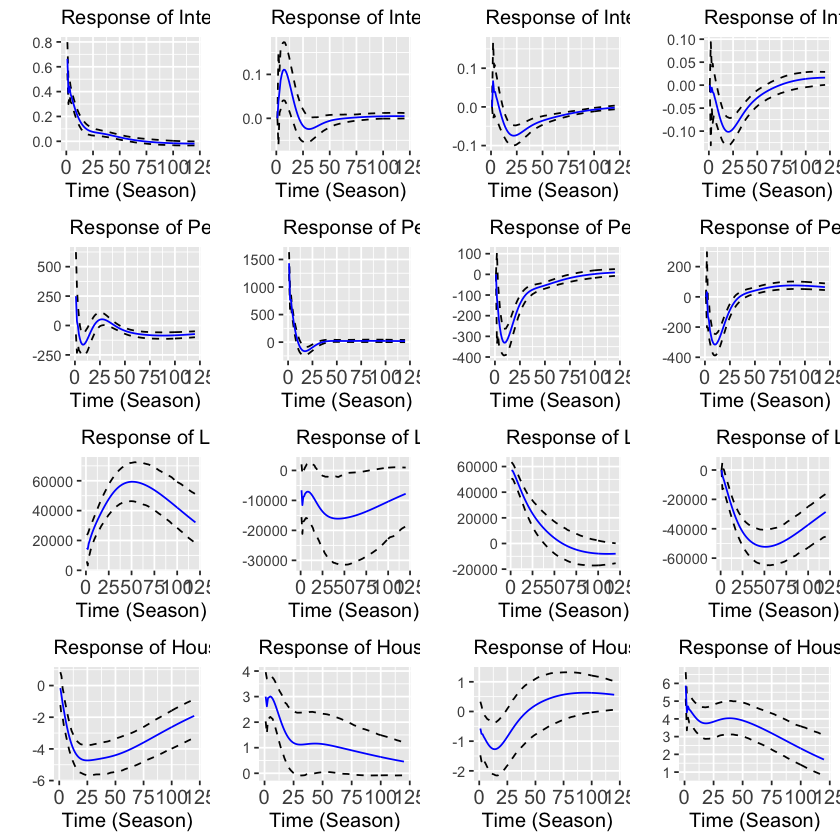

In [36]:
multiplot(p1,p2,p3,p4,
          p5,p6,p7,p8,
          p9,p10,p11,p12,
          p13,p14,p15,p16,
          cols = 4)

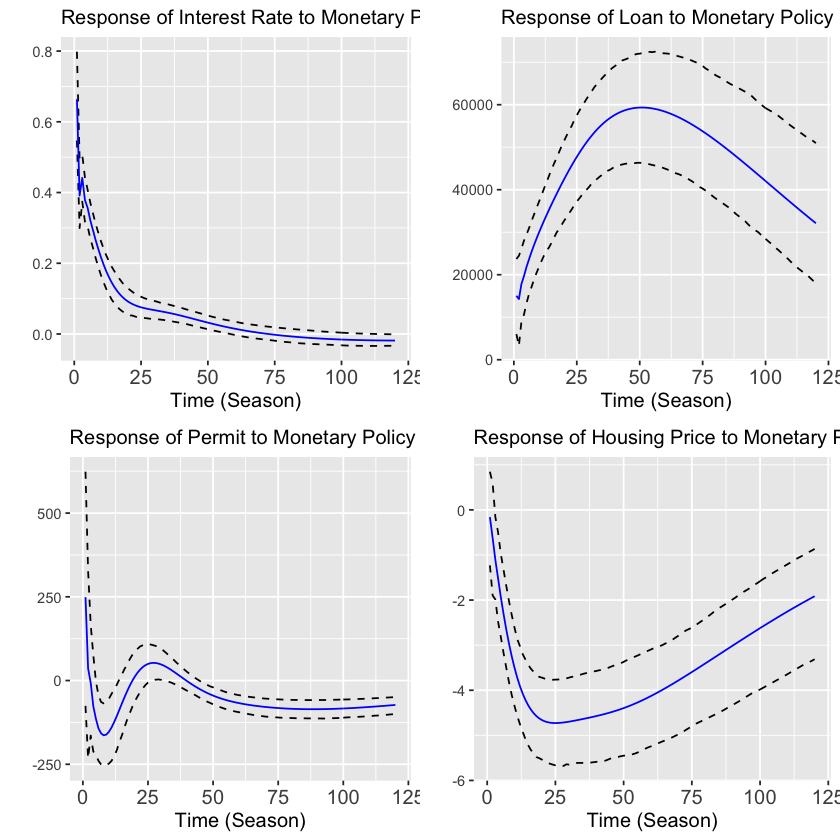

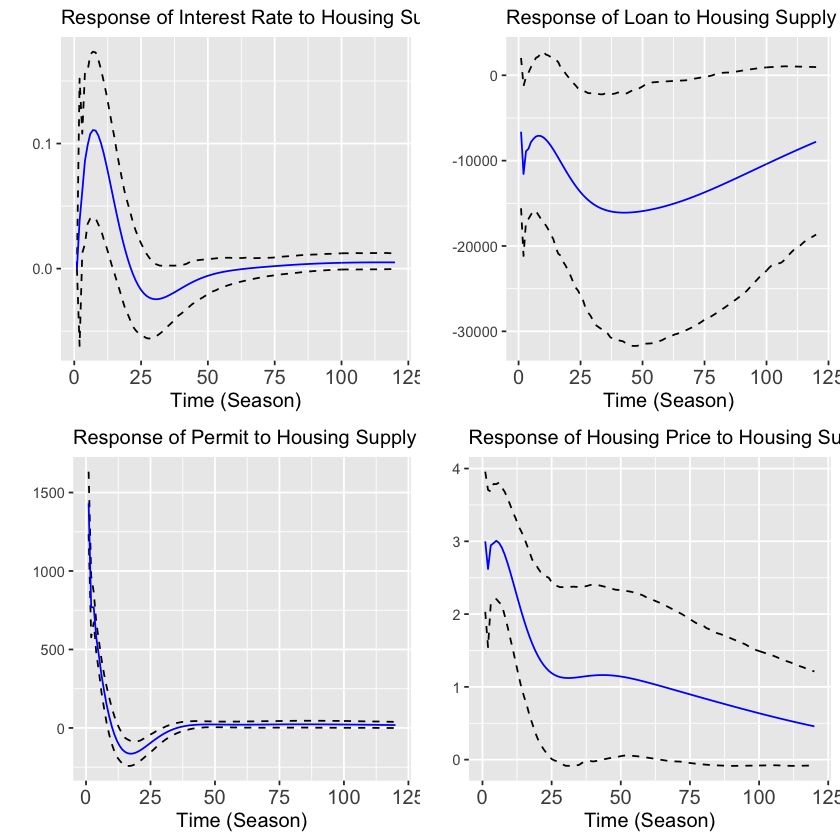

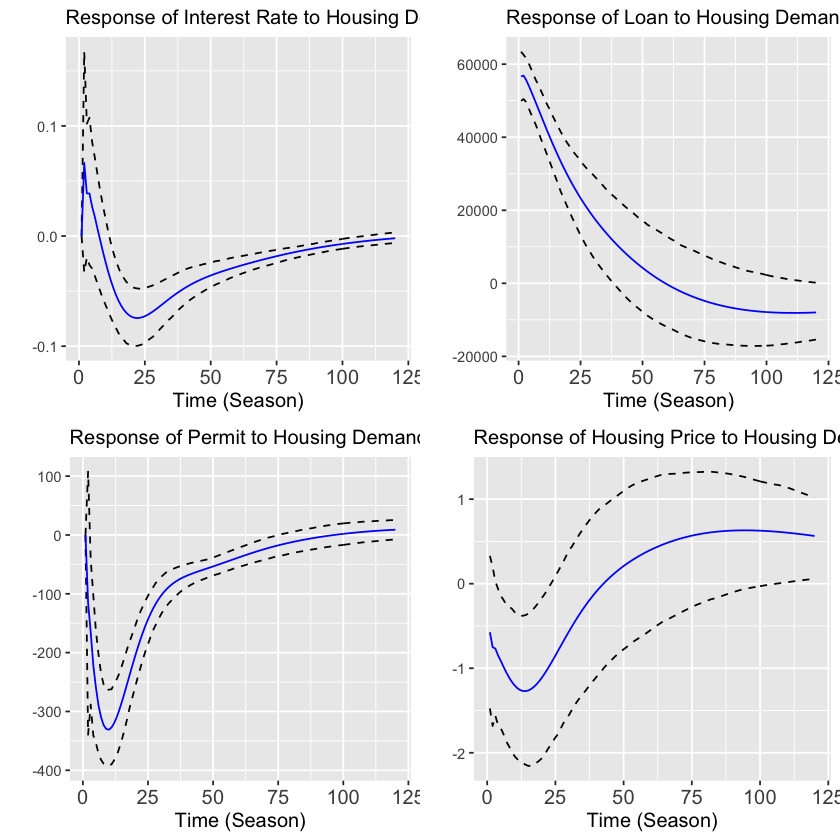

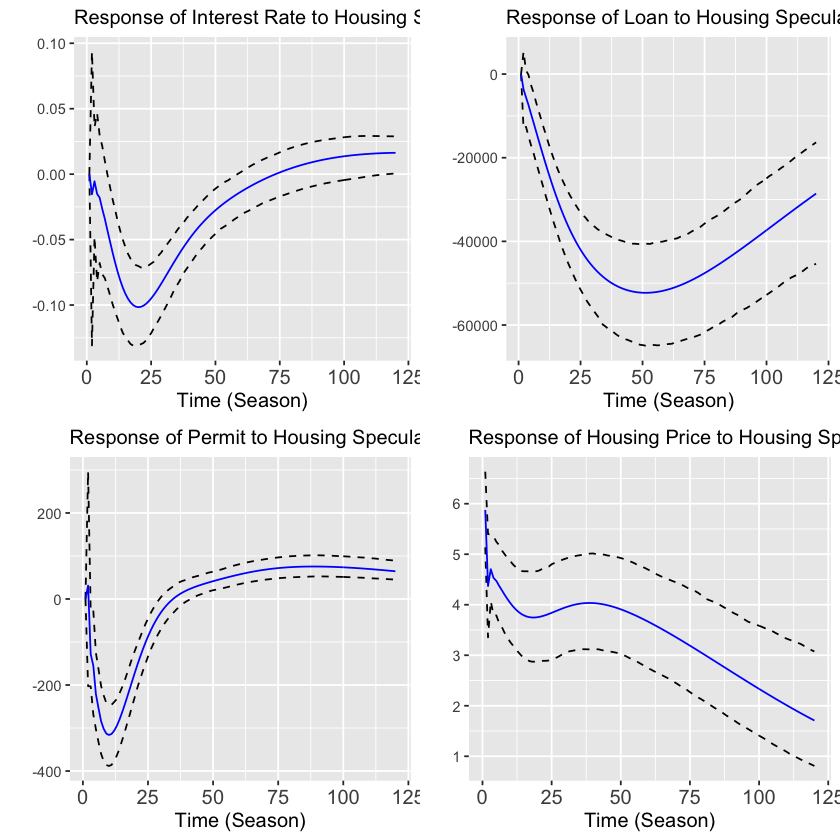

In [37]:
# For shock 1
multiplot(p1,p2,p3,p4,
          cols = 2)
# For shock 2
multiplot(p5,p6,p7,p8,
          cols = 2)
# For shock 3
multiplot(p9,p10,p11,p12,
          cols = 2)
# For shock 4
multiplot(p13,p14,p15,p16,
          cols = 2)

In [38]:
# save plot
# shock 1
ggsave(filename = "figure/SVAR_v4i1-chol_IRF_shock1.png", 
       plot = multiplot(p1,p2,p3,p4, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 1
ggsave(filename = "figure/SVAR_v4i1-chol_IRF_shock2.png", 
       plot = multiplot(p5,p6,p7,p8, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 3
ggsave(filename = "figure/SVAR_v4i1-chol_IRF_shock3.png", 
       plot = multiplot(p9,p10,p11,p12, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 4
ggsave(filename = "figure/SVAR_v4i1-chol_IRF_shock4.png", 
       plot = multiplot(p13,p14,p15,p16, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

## Variance Decomposition

In [41]:
# `ddTheta` 放已經估出來的IRF (至於要放怎樣穩定的還要再想)
# m表示對於第幾個變數的變異數分解（如第五個是對房價的變異數分解）
SVAR_AB_VarDecomp <- VAR.svardecomp.AB(m = 4, By, VAR.P,
                                       AMat, BMat, h=120,
                                       Const=TRUE, ddTheta = SVAR_AB_IRF)
tail(SVAR_AB_VarDecomp*100)

h=115,56.54868,2.535283,5.835124,35.08091
h=116,56.57078,2.531313,5.833815,35.06409
h=117,56.59188,2.527519,5.832807,35.04779
h=118,56.61202,2.523895,5.832082,35.03201
h=119,56.63123,2.520434,5.831621,35.01672
h=120,56.64955,2.517130,5.831408,35.00192


In [42]:
# table
SVAR_VD <- (SVAR_AB_VarDecomp*100) %>% as.tibble()
SVAR_VD <- SVAR_VD %>% filter(row_number(V1) %in% c(1,2,4,8,12,20,40,60,80,120)) %>%
    mutate(period = c(1,2,4,8,12,20,40,60,80,120)) %>%
    select(period = period,
           mp = V1,
           hs = V2,
           hd = V3,
           sp = V4) %>%
    mutate(mp = round(mp, digits = 2),
           hs = round(hs, digits = 2),
           hd = round(hd, digits = 2),
           sp = round(sp, digits = 2))
SVAR_VD

period,mp,hs,hd,sp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.02,9.74,0.24,90.00
2,0.41,9.20,0.55,89.84
4,2.22,10.65,1.44,85.70
8,8.29,12.13,4.01,75.56
12,15.90,11.64,7.01,65.45
20,29.50,8.71,11.33,50.47
40,45.85,4.68,10.19,39.28
60,51.79,3.41,7.46,37.35
80,54.72,2.86,6.30,36.12


In [44]:
tab_VD <- xtable(SVAR_VD, caption= "房價指數的變異數分解", align=c("c","c","c","c","c","c"))
print(tab_VD, include.rownames=FALSE)

% latex table generated in R 3.6.2 by xtable 1.8-4 package
% Sun Jan 24 04:50:41 2021
\begin{table}[ht]
\centering
\begin{tabular}{ccccc}
  \hline
period & mp & hs & hd & sp \\ 
  \hline
1.00 & 0.02 & 9.74 & 0.24 & 90.00 \\ 
  2.00 & 0.41 & 9.20 & 0.55 & 89.84 \\ 
  4.00 & 2.22 & 10.65 & 1.44 & 85.70 \\ 
  8.00 & 8.29 & 12.13 & 4.01 & 75.56 \\ 
  12.00 & 15.90 & 11.64 & 7.01 & 65.45 \\ 
  20.00 & 29.50 & 8.71 & 11.33 & 50.47 \\ 
  40.00 & 45.85 & 4.68 & 10.19 & 39.28 \\ 
  60.00 & 51.79 & 3.41 & 7.46 & 37.35 \\ 
  80.00 & 54.72 & 2.86 & 6.30 & 36.12 \\ 
  120.00 & 56.65 & 2.52 & 5.83 & 35.00 \\ 
   \hline
\end{tabular}
\caption{房價指數的變異數分解} 
\end{table}


In [45]:
print(tab_VD, file="table/SVAR_v4i1-chol.tex",
      include.rownames=FALSE,
      append=T, table.placement = "h",
      caption.placement="bottom", hline.after=seq(from=-1,to=nrow(tab_VD),by=1))

## Historical Decomposition

In [46]:
SVAR_AB_HistDecomp <- VAR.svarhist.AB(By, VAR.P, Amat, Bmat, CONST)
dim(SVAR_AB_HistDecomp)

[1] 119  16

In [47]:
#----- Base Project 估計 -----#
SVAR_AB_Hist.c0 = VAR.baseproject(By, VAR.P, CONST)
head(SVAR_AB_Hist.c0)
dim(SVAR_AB_Hist.c0)
dim(By)

1,7.180000,10465.00,1051038,98.1600
2,8.270000,17129.00,1073968,104.1600
,7.708832,17014.22,1092215,103.8355
,7.456285,17388.67,1137451,103.2655
,7.241243,17602.95,1198367,102.6222
,7.085082,17739.19,1269546,102.0915


[1] 119   4

[1] 119   4

In [48]:
# 實際時間序列與基本預測時間序列之偏離值
head(By-SVAR_AB_Hist.c0)

,interest_rate,permit,loan,hp
1,0.00000000,0.0000,0.00,0.000000
2,0.00000000,0.0000,0.00,0.000000
3,0.05783431,317.7763,19393.89,2.844501
4,-1.43361857,2785.3303,35809.59,6.724533
5,-0.86790951,1687.0481,32332.78,10.587814
6,0.63358497,6972.8067,68763.69,15.728455


In [49]:
# 只有特定衝擊下的時間序列與基本預測時間序列之偏離值
## shock1: monetary policy shock
head(SVAR_AB_HistDecomp[,c(1,5,9,13)])

NA,NA,NA,NA
NA,NA,NA,NA
0.05783431,10.07009,592.1133,-0.006096116
-1.51617327,-236.02352,-14905.5997,0.116834516
-1.12006330,-954.17743,-27352.6821,1.184167735
0.27544072,179.79706,-16443.2295,2.337723312


In [52]:
##左：baseline上 hp 的變化；右：shock1 對 hp 的衝擊
tail(cbind((By-SVAR_AB_Hist.c0)[,4], 
      (SVAR_AB_HistDecomp[,c(1,5,9,13)])[,4]))

114,-5.963901,3.877579
115,-8.980548,3.732095
116,-7.730505,3.623662
117,-9.003796,3.551124
118,-5.280456,3.523773
119,1.539467,3.583257


### 對「房價」的歷史分解：monetary policy shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


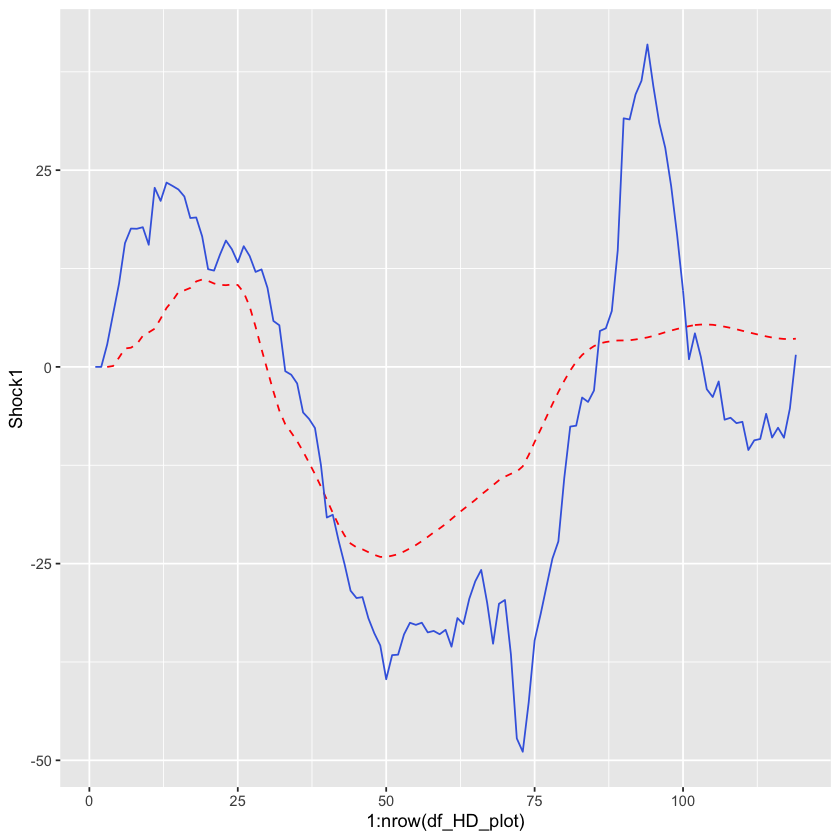

In [53]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,4],
                        (SVAR_AB_HistDecomp[,c(1,5,9,13)])[,4])
colnames(df_HD_plot) <- c("BaseLine", "Shock1")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock1), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')


### 對「房價」的歷史分解：supply shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


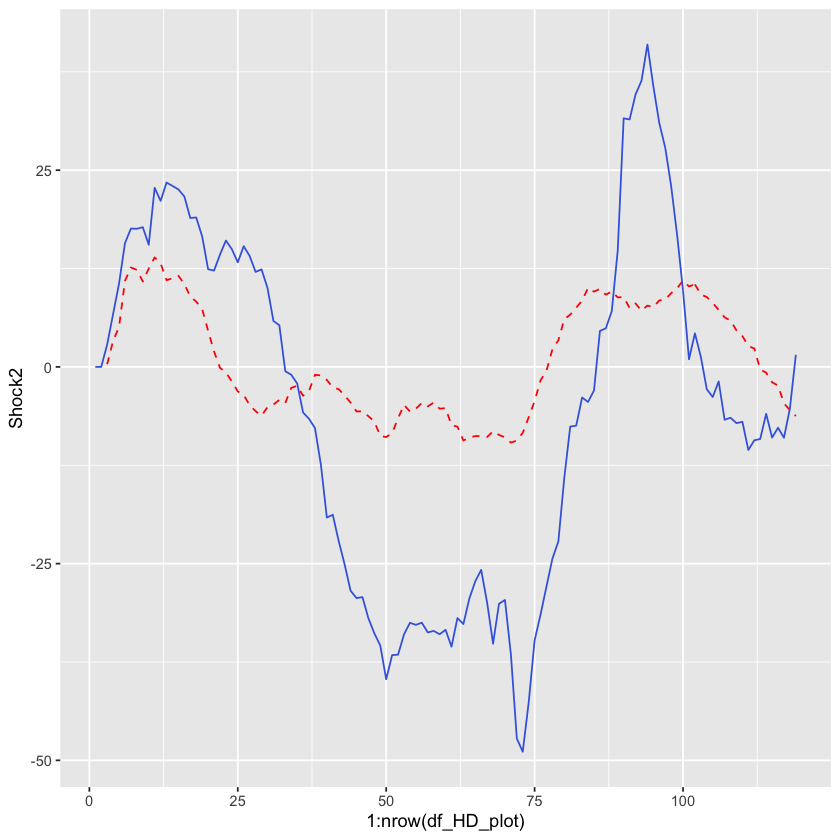

In [54]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,4],
                        (SVAR_AB_HistDecomp[,c(2,6,10,14)])[,4])
colnames(df_HD_plot) <- c("BaseLine", "Shock2")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock2), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### 對「房價」的歷史分解：demand shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


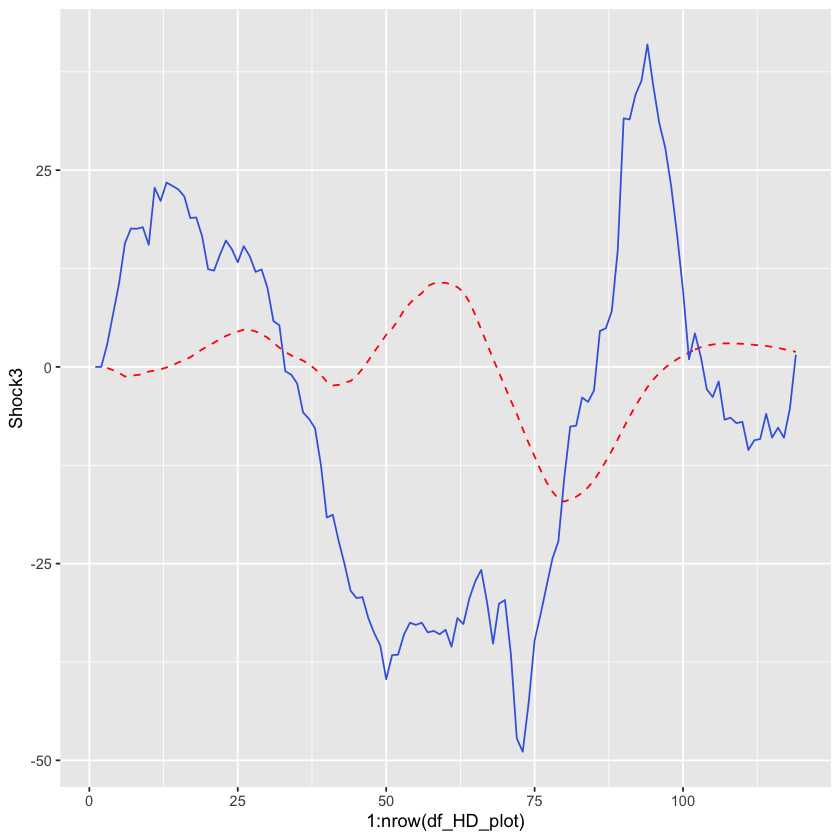

In [55]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,4],
                        (SVAR_AB_HistDecomp[,c(3,7,11,15)])[,4])
colnames(df_HD_plot) <- c("BaseLine", "Shock3")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock3), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### 對「房價」的歷史分解：housing speculation shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


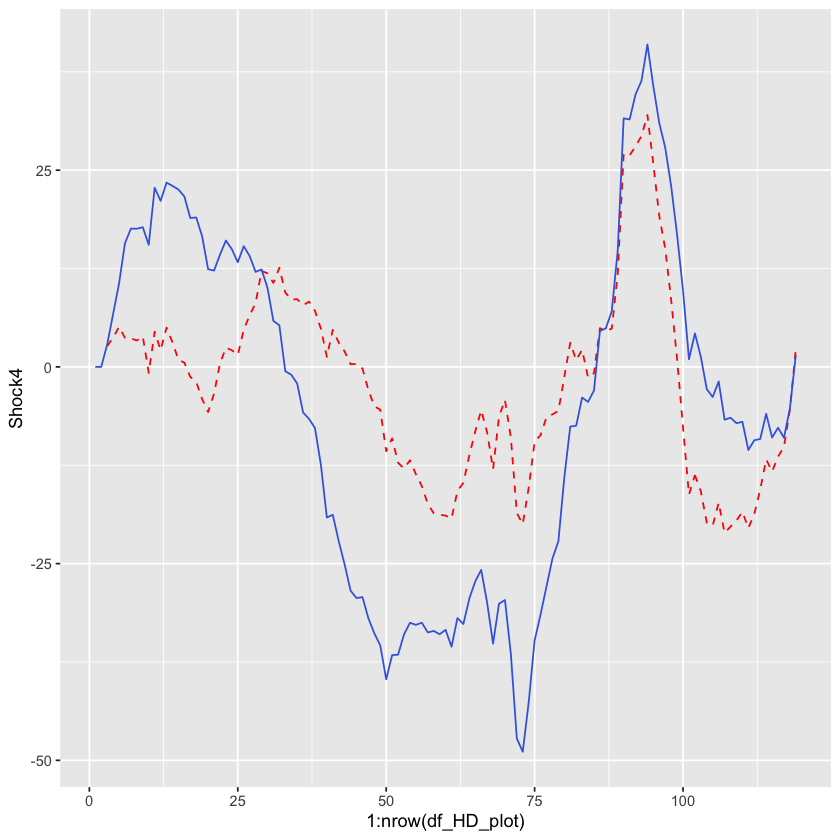

In [56]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,4],
                        (SVAR_AB_HistDecomp[,c(4,8,12,16)])[,4])
colnames(df_HD_plot) <- c("BaseLine", "Shock4")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock4), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### Table

In [57]:
t_label <- c()
year_label <- c()
season_label <- c()
year <- 1991
for(q in 1:119){
    if(q%%4==0){
        t_label <- c(t_label, paste0(year, "Q4", sep = ""))
        year_label <- c(year_label, year)
        season_label <- c(season_label, 4)
        year <- year+1
    }else{
        t_label <- c(t_label, paste0(year, "Q", q%%4, sep = ""))
        year_label <- c(year_label, year)
        season_label <- c(season_label, q%%4)
    }
}

In [58]:
df_HD <- bind_cols(t_label,
                   year_label,
                   season_label,
                   (By-SVAR_AB_Hist.c0)[,4],
                   SVAR_AB_HistDecomp[,13],
                   SVAR_AB_HistDecomp[,14],
                   SVAR_AB_HistDecomp[,15],
                   SVAR_AB_HistDecomp[,16])
colnames(df_HD) <- c("Time", "Year", "Season", "BaseLine", "mp", "hs", "hd", "sp")
tail(df_HD)

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3
* NA -> ...4
* NA -> ...5
* ...



Time,Year,Season,BaseLine,mp,hs,hd,sp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019Q2,2019,2,-5.963901,3.877579,-0.7437301,2.656440,-11.754191
2019Q3,2019,3,-8.980548,3.732095,-1.9689097,2.549488,-13.293221
2019Q4,2019,4,-7.730505,3.623662,-2.3670201,2.414201,-11.401348
2020Q1,2020,1,-9.003796,3.551124,-4.6305151,2.249449,-10.173854
2020Q2,2020,2,-5.280456,3.523773,-5.4939818,2.096791,-5.407038
2020Q3,2020,3,1.539467,3.583257,-6.2525997,1.901620,2.307189


In [59]:
# 全樣本
HD_seq1 <- df_HD %>% summarise(Time = Time,
                    Year = Year,
                    Season = Season,
                    mp = mp/BaseLine*100,
                    hs = hs/BaseLine*100,
                    hd = hd/BaseLine*100,
                    sp = sp/BaseLine*100) %>%
drop_na() %>%
summarise(mp = median(mp),
          hs = median(hs),
          hd = median(hd),
          sp = median(sp))

# 房價持平期
HD_seq2 <- df_HD %>% summarise(Time = Time,
                    Year = Year,
                    Season = Season,
                    mp = mp/BaseLine*100,
                    hs = hs/BaseLine*100,
                    hd = hd/BaseLine*100,
                    sp = sp/BaseLine*100) %>%
drop_na() %>%
filter(Year<2003) %>%
summarise(mp = median(mp),
          hs = median(hs),
          hd = median(hd),
          sp = median(sp))

# 房價上升期
HD_seq3 <- df_HD %>% summarise(Time = Time,
                    Year = Year,
                    Season = Season,
                    mp = mp/BaseLine*100,
                    hs = hs/BaseLine*100,
                    hd = hd/BaseLine*100,
                    sp = sp/BaseLine*100) %>%
drop_na() %>%
filter(Year>=2003) %>%
summarise(mp = median(mp),
          hs = median(hs),
          hd = median(hd),
          sp = median(sp))

In [60]:
HD_seq <- bind_rows(HD_seq1, HD_seq2, HD_seq3)
HD.table <- bind_cols(c("全樣本(1991Q1-2020Q3)","房價持平期(1991Q1-2002Q4)","房價上升期(2003Q1-2020Q3)"), HD_seq)
colnames(HD.table) <- c("樣本期間", 
                        "Montary Policy Shock", 
                        "Housing Supply Shock",
                        "Housing Demand Shock",
                        "Housing Speculation Shock")
HD.table

New names:
* NA -> ...1



樣本期間,Montary Policy Shock,Housing Supply Shock,Housing Demand Shock,Housing Speculation Shock
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
全樣本(1991Q1-2020Q3),42.15278,19.62370,-2.944631,27.75035
房價持平期(1991Q1-2002Q4),63.17954,20.03794,3.975266,6.61404
房價上升期(2003Q1-2020Q3),25.83776,19.62370,-16.203125,45.08038


In [61]:
# 生出table
tab_HD <- xtable(HD.table, caption= "歷史分解下各衝擊的解釋力比率(%)", align=c("c","c","c","c","c","c"))
print(tab_HD, include.rownames=FALSE)

% latex table generated in R 3.6.2 by xtable 1.8-4 package
% Sun Jan 24 04:54:23 2021
\begin{table}[ht]
\centering
\begin{tabular}{ccccc}
  \hline
樣本期間 & Montary Policy Shock & Housing Supply Shock & Housing Demand Shock & Housing Speculation Shock \\ 
  \hline
全樣本(1991Q1-2020Q3) & 42.15 & 19.62 & -2.94 & 27.75 \\ 
  房價持平期(1991Q1-2002Q4) & 63.18 & 20.04 & 3.98 & 6.61 \\ 
  房價上升期(2003Q1-2020Q3) & 25.84 & 19.62 & -16.20 & 45.08 \\ 
   \hline
\end{tabular}
\caption{歷史分解下各衝擊的解釋力比率(%)} 
\end{table}


In [62]:
print(tab_HD, include.rownames=FALSE,
      file="table/SVAR_v4i1-chol_HD.tex",
      append=T, table.placement = "h",
      caption.placement="bottom", hline.after=seq(from=-1,to=nrow(tab_HD),by=1))

### Save Plot

In [63]:
xlab <- lubridate::yq(df_HD$Time)

In [65]:
# plot 1
figure_HD.1 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = mp, color = "Monetary Policy Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "HP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of hp: Monetary Policy Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

# plot 2
figure_HD.2 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = hs, color = "Housing Supply Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "HP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of hp: Housing Supply Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('red','royalblue'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

# plot 3
figure_HD.3 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = hd, color = "Housing Demand Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "HP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of hp: Housing Demand Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('red','royalblue'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

# plot 4
figure_HD.4 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = sp, color = "Housing Speculation Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "HP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of hp: Housing Speculation Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('red','royalblue'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

In [70]:
# save shock 1
ggsave(filename = "figure/SVAR_v4i1-chol_HD_shock1.png", 
       plot = figure_HD.1,
       width = 15, height = 10, units = "cm",
       device = "png")

# save shock 2
ggsave(filename = "figure/SVAR_v4i1-chol_HD_shock2.png", 
       plot = figure_HD.2,
       width = 15, height = 10, units = "cm",
       device = "png")

# save shock 3
ggsave(filename = "figure/SVAR_v4i1-chol_HD_shock3.png", 
       plot = figure_HD.3,
       width = 15, height = 10, units = "cm",
       device = "png")

# save shock 4
ggsave(filename = "figure/SVAR_v4i1-chol_HD_shock4.png", 
       plot = figure_HD.4,
       width = 15, height = 10, units = "cm",
       device = "png")

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
